# Network analysis with GTR data

This notebook contains code to replicate the analysis in the Nesta blog about Welsh research networks. It takes 
a dataframe of projects (output of the topic classification notebook) and produces relevant network graphs and
figures. Most of this is done using a group of functions for extracting, transforming and selecting networks.

## 1. Preamble: imports and functions

In [1]:
%matplotlib inline

#Imports
import json
import matplotlib.pyplot as plt
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns

#For network analysis and community detection
from itertools import combinations
import networkx as nx

#Path for visual outputs:
net_path = "insert_path_here"
img_path = "insert_path_here"

In [2]:
#A note on the pipeline to produce network outputs
#The pipeline looks complicated, partly because the functions are written in general
#terms and take lots of arguments. 

#It does the following:

#extract_network_from_corpus: takes a df with rows = collaborative projects and variable = list of collaborators
    #and creates a networks with edges between nodes. It groups this to generate weight >1 where there are
    #multiple connections between nodes. It also does this taking into account that the kinds of relations can 
    #be different (in our case, there are different disciplines)
#extract_network_of_interest: It calls extract_network_from_corpus to obtain a network object where the nodes
    #are collaborators, the edges are collaborative projects, and the edge attributes are collaboration disciplines.
#subset_by_edge_attribute: Subsets the network by a value of the edge attribute (say, a specific discipline)
#extract_network_statistics: this function is too long and perhaps should be simplified. It takes a network and 
    #extracts relevant network statistics.
#compare_networks: produces network graphs. !!! There is a bug preventing the export of network objects as figures.
    #We need to fix this.

#It is perhaps easier to understand what all these functions do by taking a look at [436], where we use
    #them to obtain some analytical outputs for the Welsh network. This analysis can be trivially replicated
    #for other countries or even regions (although we need to load a new lookup for that)

In [4]:
def extract_network_from_corpus(label_corpus,edge_attr="None",stop_words=None):
    """
    Extracts a network object from a list or series where every observation is a list of co-ocurring observations
    (e.g. interacting agents, or co-occurring words). 
    In the network output, the labels are nodes and co-occurrences between them are edges. 
    Weight is number of co-occurrences. There is the option to consider additional edge attributes.

    Inputs:
    label_corpus: corpus of documents with label co-occurrence or node interaction.
    edge_attr: an edge attribute associated to the interaction. It defaults to the string none (which we use
        for control flow)
    stop_words: labels to remove (e.g. generic terms)
    
    Returns a networkx object.
    
    """
    label_pairs_container =[]
    
    #!!! TODO Using type to control flow feels a bit hacky.
    if type(edge_attr) != str:
        #Container for pairs of labels
        edge_attr_name = edge_attr.name
    
    #For each pair
    for i in range(len(label_corpus)):
    
    #List of tuples where every tuple is a combination of topics
        pairs = list(combinations(label_corpus[i],2))
    
    #Extract these as lists of dicts capturing connections between topics, and add those to the container.
    #NB we are sorting the tuples to make sure that we don't duplicate edges.
        if len(pairs)>0:
            cont = [{'e1':sorted(tup)[0],'e2':sorted(tup)[1]} for tup in pairs]
            
            #Give each edge its corresponding attribute (if we have one)
            if type(edge_attr) != str:
                for d in cont:
                    d.update({edge_attr_name: edge_attr[i]})

            label_pairs_container.append(cont)

    #Flatten dict list and turn into DF
    label_pairs_df = pd.DataFrame([ds for sublist in label_pairs_container for ds in sublist])
    
    #Extract weights (depends on edge_attr)
    if type(edge_attr) != str:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2',edge_attr_name]
                                                        ).size()).reset_index().sort(columns=0,ascending=False)
    else:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2']
                                                        ).size()).reset_index().sort(columns=0,ascending=False)
    
    label_edgelist.rename(columns={0:'weight'},inplace=True)
    
    #Remove stop-words
    if stop_words != None:
        has_ttm =  [x in stop_words or y in stop_words for x,y in zip(label_edgelist['e1'],label_edgelist['e2'])]
        label_edgelist = label_edgelist[-pd.Series(has_ttm)]
    
    #Create label graph
    if type(edge_attr) != str:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight',edge_attr_name])
    else:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight'])
    
    return(label_graph)   

def extract_network_of_interest(interaction_df,
                                interaction_index="project_id", 
                                node="name", 
                                var_interest="country",
                                val_interest="Wales",
                                edge_attr="topic_classified"):
    """
    This function selects all interactions in a df involving nodes with a certain attribute, and 
    returns a network object. It is a multigraph with multiple edges depending on edge attributes.
        
    Input: a df where at least one of the columns is an "interaction" id_var, another contains the orgs involved
        #and another contains the variable of interest we want to subset by (with val_interest) and a variable
        #with edge attributes
    Returns: A networkx object
    
    """
    #Create grouped object
    group_by_interaction = interaction_df.groupby(interaction_index)
    
    #If we are interested in specific interactions, select those.
    
    if var_interest != None:
        relevant_interactions = [name for name,group in group_by_interaction if 
                                 val_interest in list(group[var_interest])]
        
        #Create relevant df that selects the relevant interactions
        relevant_df = interaction_df[[i in relevant_interactions for i in interaction_df[interaction_index]]]
    else:
        relevant_df = interaction_df
        
    #Create a corpus (a df with collections of interactions)
    interacting_sets = relevant_df.groupby(interaction_index)[node].apply(lambda x: list(x)).reset_index()
    interacting_attr = relevant_df.groupby(interaction_index)[edge_attr].apply(lambda x: list(x)[0]).reset_index()
    interactions = pd.merge(interacting_sets,interacting_attr,on=interaction_index)

    org_network_all = extract_network_from_corpus_mod(interactions[node],
                                      edge_attr=interactions[edge_attr])
    
    return(org_network_all)

def subset_by_edge_attribute(network, attribute_val,attribute_name="topic_classified"):
    """
    This function takes a multigraph (network where nodes can be connected by more than one type of edge) and
    subsets it by a single edge attribute. In this project, we are using it to extract collaborations between
    networks in specific disciplines from a network with collaborations for all disciplines.
    
    Input: a nx object, an edge attribute and an attribute_val to select nodes and edges
    Output: a pruned network only considering edges with that attribute
    """
    
    #Important to create a copy of the network, otherwise we transform the original: oopsie.
    network2 = network.copy()
    
    #Returns edges that fail the test.
    edges_not_fulfil = [(u,v) for u,v,d in network.edges_iter(data=True) if d[attribute_name]!=
                   attribute_val]
    #Removes them
    network2.remove_edges_from(ebunch=edges_not_fulfil)
    
    #Identifies and drops the resulting solitary nodes
    solitary_nodes =[n for n,d in network2.degree_iter() if d==0]

    network2.remove_nodes_from(solitary_nodes)
    
    return(network2)

def extract_network_statistics(network,attribute_pair={"country":"Wales"}):
    """
    This function takes a labelled network and a selector (attribute-value pair, defaults to "country":"Wales") 
    and extracts some statistics of interest, including:
    
        Subset node connectivity:
            Number of connected component (after we remove nodes without selected attribute)
            Relative size of the largest connected component
            Number of isolated nodes after we remove nodes without selected attribute.

        Selected node influence
            Average betweenness centrality and eigenvector centrality of orgs with selected attribute.
            Number of Welsh orgs in top quartile of centrality; identity

        Other influencial players in networks
            Top 5 players in each discipline in terms of betweenness, eigenvector centrality

        #It returns a table with the stats and a dict with identities of relevant orgs
    
    """
    #Create copy of the network
    network_copy = network.copy()

    #Extract metadata (graph attributes)
    labels = network_copy.graph.values()
    
    #Extract selector variable and value
    sel_var = attribute_pair.keys()[0]
    sel_val = attribute_pair.values()[0]

    #BASIC STATS
    #1. Number of nodes
    nodes_n = int(len(network_copy.node))
    
    #2. Proportion of nodes with selected attribute
    nodes_select_n = int(len([n for n in network_copy.node if network_copy.node[n][sel_var]==sel_val]))
    nodes_select_prop = np.round(nodes_select_n/float(nodes_n),3)
    
    #CONNECTIVITY
    #Create subgraph with only relevant  nodes
    network_selected = network_copy.subgraph([n for n in network_copy.nodes_iter() if
                                             network_copy.node[n][sel_var]==sel_val])
    
    #Extract connected components
    conn_comps = list(nx.components.connected_components(network_selected))

    #1. Number of connected components
    conn_comps_n = int(len(conn_comps))

    #2. Size of biggest connected component (also as proportion of total)
    conn_comp_sizes = [len(d) for d in conn_comps]
    
    largest_comp_size = max(conn_comp_sizes)
    largest_comp_size_prop = np.round(float(largest_comp_size)/sum(conn_comp_sizes),3)
                                                                             
    #3. Isolated nodes
    isolated_nodes_n = sum([d ==1 for d in conn_comp_sizes])
    isolated_nodes_prop= np.round(float(isolated_nodes_n)/nodes_select_n,3)
    

    #CENTRALITY
    #Create dicts with keys=org names, values = centrality scores for org.
    #We will use two main centrality measures.
    #Eigenvalue centrality considers the influence of the nodes a node is connected with 
    #Betweenness centrality considers the "brokerage" role of a node (number of shortest paths it sits in)
        
    #Extract dicts
    eigen_scores_dict = nx.centrality.eigenvector_centrality(network_copy,weight="weight")
    betw_scores_dict = nx.centrality.betweenness_centrality(network_copy,weight="weight")
    
    #Place dicts in DataFrame
    centr_scores = pd.merge(pd.DataFrame({"org": eigen_scores_dict.keys(),
                                 "eig_c": eigen_scores_dict.values()}
                               ),
                            pd.DataFrame({"org":betw_scores_dict.keys(),
                                         "bet_c": betw_scores_dict.values()}),
                           on="org")
    
    #Create a country variable
    centr_scores[sel_var]=[network_copy.node[n][sel_var] for n in centr_scores['org']]
    
    
    #1. Identify selected central orgs (they are in the top quartile for the centrality measure)
    selected_central_eig = [org for org,eig,sel_v in zip(centr_scores['org'],
                                                  centr_scores['eig_c'],
                                                 centr_scores[sel_var]) 
                     if eig > centr_scores['eig_c'].quantile(0.75) and sel_v==sel_val]
    
    #Proportion of selected orgs in the top quartile for eigenvector centrality
    selected_central_eig_prop = np.round(float(len(selected_central_eig))/(len(centr_scores)/4),3)

    #2. Identify selected central orgs (they are in the top quartile for the betweenness centrality measure)
    #!!! TODO: repeating ourselves. This should be a function
    selected_central_bet = [org for org,bet,sel_v in zip(centr_scores['org'],
                                                  centr_scores['bet_c'],
                                                 centr_scores[sel_var]) 
                     if bet > centr_scores['bet_c'].quantile(0.75) and sel_v==sel_val]
    
    #Proportion of selected orgs in the top quartile for betweeneness centrality
    selected_central_bet_prop = np.round(float(len(selected_central_bet))/(len(centr_scores)/4),3)


    #Identify influential non-selected orgs (e.g. non Welsh organisations with high centrality in the network)
    #This takes the top 5.
    non_selected_central_eig = centr_scores[centr_scores[sel_var]!=sel_val].sort("eig_c",ascending=False)[0:5]['org']
    non_selected_central_bet = centr_scores[centr_scores[sel_var]!=sel_val].sort("bet_c",ascending=False)[0:5]['org']

    #Outputs
    #DataFrame
    
    my_variables = [nodes_n,nodes_select_n,nodes_select_prop,
        conn_comps_n,largest_comp_size,largest_comp_size_prop,isolated_nodes_n,isolated_nodes_prop,
        selected_central_eig_prop,selected_central_bet_prop]
    variable_names = ['nodes_n','nodes_{}_n'.format(sel_val),'nodes_{}_prop'.format(sel_val),
        'conn_comps_n','largest_comp_size','largest_comp_size_prop','isolated_nodes',"isolated_nodes_prop",
        '{}_central_eig_prop'.format(sel_val),'{}_central_bet_prop'.format(sel_val)]
    
    output_df = pd.DataFrame(
        my_variables,
        index=variable_names,
        columns=["_".join(labels)])
        
    output_dict = {"_".join(labels):
                   {"central_{}_eig".format(sel_val):selected_central_eig,
                  "central_{}_bet".format(sel_val):selected_central_bet,
                  "central_non_{}_eig".format(sel_val):[non_selected_central_eig],
                  "central_non_{}_bet".format(sel_val):[non_selected_central_bet]}}

    return([output_df,output_dict])

def compare_networks(disc_network,country,discipline_name):
    """
    This function outputs a figure comparing the discipline collaboration network for a country including
    all nodes in the network (i.e. also including some nodes from other countries), 
    and another that only considers the nodes from the country of interest
    
    Input:
    -A discipline nx network object (output from previous analysis)
    -Country: The name of the country (to select nodes in the subset network)
    -Discipline_name: Name of the discipline for the chart title.
    """
    node_meta_map = {"England":"blue","Wales":"red","Scotland":"green"}
    
    disc_network_c = disc_network.copy()
    #Create a node color and size
    
    my_node_col = [node_meta_map[disc_network_c.node[n]['country']] for n in disc_network_c.nodes_iter()]
    my_node_size = [d[1]*4 for d in disc_network_c.degree_iter()]
    #my_node_weight = [e['weight'] for u,v,e in disc_network.edges_iter()]


    #Create a node selector to subset
    node_sel = [n for n in disc_network_c.nodes_iter() if disc_network_c.node[n]['country']==country]

    network_sub = disc_network_c.subgraph(node_sel)
    
    sub_node_size = [(d[1]*4)+1 for d in network_sub.degree_iter()]
    #sub_node_weight = [e['weight'] for u,v,e in sub_node.edges_iter()]
    
    comp_network_figure, ax = plt.subplots(1, 2, figsize=(10, 4))

    nx.draw_spring(disc_network_c,
                   node_size=my_node_size,
                   node_color=my_node_col,ax=ax[0])
    nx.draw_spring(network_sub,
                   node_size=sub_node_size,
                   node_color="red",ax=ax[1])
    ax[0].set_title("Network with all organisations",y=0.97)
    ax[1].set_title("Network with Welsh organisations",y=0.97)
    comp_network_figure.suptitle("{} network".format(discipline_name),size=14,y=1.01)
    
    return(comp_network_figure)

def get_lq(dist_df):
    """
    Function to produce location quotients based on a contingency table (e.g. geographical distribution of activity)
    Assumes that rows = observations (e.g. places) and columns = variables (e.g. industry, sector of activity)
    
    #Input:
    #A contingency table (output of pd.crosstab(unit,variable))
    #Returns a table with location quotients (and one variable with labels for plotting)
    """
    column_counts = dist_df.sum(axis=1).reset_index()
    
    props =  dist_df.apply(lambda x: x/dist_df.sum(axis=1))
    lqs = props.apply(lambda x: x/(dist_df.sum(axis=0)/dist_df.sum().sum()),axis=1).reset_index()
    
    lqs_w_counts = pd.merge(lqs,column_counts,on=lqs.columns[0])
    lqs_w_counts.rename(columns={0:"total_projects"},inplace=True)
    
    return(lqs_w_counts)

In [ ]:
#Run the topic classification notebook.
%run '../topic_analysis/gateway-to-research-topic-classification.ipynb'

In [ ]:
#Load lookup tables that will be used later

#Organisation-LAD lookup
#(NB I had to read and write this in Python 3 due to backward incompatibility in encoding protocols)
lad_lut = pd.read_pickle("lut2.p")
lad_lut.reset_index(inplace=True,drop=True)
lad_lut.head()


#Get LAD-country lookup (download from 
#https://geoportal.statistics.gov.uk/geoportal/catalog/content/filelist.page?&pos=4&cat=#LU)
lad_lookup_path ='put_path_here'

#Read file
lad_country_lookup = pd.read_csv(lad_lookup_path)
print(lad_country_lookup.head())

#Create list of names for Welsh LADs
welsh_lads = list(lad_country_lookup.ix[lad_country_lookup.CTRY13NM=="Wales","LAD13NM"])

#Merge with the lad_lut to create an organisation - country lookup
org_geo_lut = pd.merge(lad_lut,lad_country_lookup,left_on="lad",right_on="LAD13CD")
org_geo_lut.tail()

#Turn this into a dict for labelling nodes later
org_geo_lut_indexed = org_geo_lut.set_index("name",drop=True)
org_geo_lu_dict = pd.DataFrame.to_dict(org_geo_lut_indexed,orient="index")

## 2. Create organisational network

In this network, the nodes are organisations, the edges are joint projects, the attributes of the edges are their research domains. The node metadata captures locations.

In [39]:
#Extract org identities from the projects_df
project_links_list = [i['link'] for i in projects_df['links']]
[i.update({"id":my_id}) for sublist,my_id in zip(project_links_list,projects_df['id']) for i in sublist]

In [47]:
#1 flatten the link field
#Extract data from link field in the projects_df
project_links_unpacked = [pd.DataFrame(i['link'])for i in projects_df['links']]
project_links_df = pd.concat(project_links_unpacked)

#Clean df
project_links_df.reset_index(inplace=True,drop=True)
project_links_df.drop('otherAttributes',axis=1,inplace=True)
project_links_df.rename(columns={"id":"project_id"},inplace=True)
project_links_df.head()

,end,href,project_id,rel,start
0,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/persons/A1978...,3EBFD795-CD31-4850-9676-C08B769B3A46,PI_PER,NaN
1,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,3EBFD795-CD31-4850-9676-C08B769B3A46,LEAD_ORG,NaN
2,1.154300e+12,http://gtr.rcuk.ac.uk:80/gtr/api/funds/14A7FBE...,3EBFD795-CD31-4850-9676-C08B769B3A46,FUND,1.146438e+12
3,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/outcomes/publ...,3EBFD795-CD31-4850-9676-C08B769B3A46,PUBLICATION,NaN
4,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/persons/1EB3E...,3F0EC91C-7E09-4EE7-ABEB-BE1BA33556A6,PM_PER,NaN


In [49]:
#Extract organisation id data
project_links_df['org_id'] = project_links_df['href'].map(lambda x: x.split("/")[-1])

#Merge with org addresses (!!! NB this merge only considers organisations with LAD data: excludes overseas orgs!)
project_links_geo_df = pd.merge(project_links_df,
                               lad_lut,left_on="org_id",right_on="id",how="inner")
project_links_geo_df.head()

,end,href,project_id,rel,start,org_id,name,id,lad
0,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,3EBFD795-CD31-4850-9676-C08B769B3A46,LEAD_ORG,NaN,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,46B41008-0EB4-4E28-BBFB-E98366999EC5,E06000047
1,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,662AEC23-1B71-47EA-9F84-D29D75C12CD7,LEAD_ORG,NaN,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,46B41008-0EB4-4E28-BBFB-E98366999EC5,E06000047
2,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,9BF3CEC5-3892-42A1-B65F-FB0DE83E82C0,LEAD_ORG,NaN,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,46B41008-0EB4-4E28-BBFB-E98366999EC5,E06000047
3,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,DAA6C296-9650-40DC-A561-F89664E54C58,LEAD_ORG,NaN,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,46B41008-0EB4-4E28-BBFB-E98366999EC5,E06000047
4,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,D7718929-7296-4CB0-89FC-FCCD1164EC81,LEAD_ORG,NaN,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,46B41008-0EB4-4E28-BBFB-E98366999EC5,E06000047


In [51]:
#Merge the geo-coded organisations with the original project df to create the project (topic) - org link. We will 
    #use this for mapping later
#!!! This still includes a bunch of innovate_uk projects. Can deal with this by removing projects with null topics.
relevant_proj_fields = ["grant_cats","href","id","status","titles","topic_list","aggregated_topics","topic_classified"]
relevant_org_fields = ['project_id','rel','org_id','name','lad']

projects_org_df = pd.merge(project_links_geo_df[relevant_org_fields],project_labelled_df[relevant_proj_fields],
                            left_on="project_id",right_on="id",how="inner",sort=False)

#Subset and focus on relevant subjects
projects_org_df_short = projects_org_df[['project_id','rel','org_id','name','lad','topic_classified']]
projects_org_df_short.head()

In [208]:
#Merge lookup with labelled projects df and projects df.
places_projects_orgs_df = pd.merge(projects_org_df,
                                 lad_country_lookup,left_on="lad",
                                 right_on="LAD13CD",how="left")
places_projects_orgs_df.rename(columns={'CTRY13NM': 'country','LAD13NM':'lad_name'},inplace=True)
places_projects_orgs_df.head()

,project_id,rel,org_id,name,lad,grant_cats,href,id,status,titles,topic_list,aggregated_topics,topic_classified,LAD13CD,LAD13CDO,lad_name,CTRY13CD,CTRY13CDO,country
0,3EBFD795-CD31-4850-9676-C08B769B3A46,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/3EBF...,3EBFD795-CD31-4850-9676-C08B769B3A46,Closed,W.G. Sebald: Modernity and the Archive,"[German, inc. Dutch & Yiddish]",[Arts and Humanities],Arts and Humanities,E06000047,00EJ,County Durham,E92000001,921,England
1,662AEC23-1B71-47EA-9F84-D29D75C12CD7,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/662A...,662AEC23-1B71-47EA-9F84-D29D75C12CD7,Closed,Mathematical Aspects of Graphical Models: An L...,[Statistics & Appl. Probability],[Mathematics and Computing],Mathematics and Computing,E06000047,00EJ,County Durham,E92000001,921,England
2,9BF3CEC5-3892-42A1-B65F-FB0DE83E82C0,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/9BF3...,9BF3CEC5-3892-42A1-B65F-FB0DE83E82C0,Active,The mechanistic basis of plant NLR signalling ...,"[Protein expression, Interaction with organism...","[Life Sciences, Life Sciences, Life Sciences]",Life Sciences,E06000047,00EJ,County Durham,E92000001,921,England
3,DAA6C296-9650-40DC-A561-F89664E54C58,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/DAA6...,DAA6C296-9650-40DC-A561-F89664E54C58,Active,Rydberg crystals and supersolids,[Cold Atomic Species],[Engineering and Technology],Engineering and Technology,E06000047,00EJ,County Durham,E92000001,921,England
4,D7718929-7296-4CB0-89FC-FCCD1164EC81,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/D771...,D7718929-7296-4CB0-89FC-FCCD1164EC81,Closed,Dynamics &amp; deposits of braid-bars in the W...,"[Sediment/Sedimentary Processes, Earth Surface...","[Environmental Sciences, Environmental Sciences]",Environmental Sciences,E06000047,00EJ,County Durham,E92000001,921,England


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


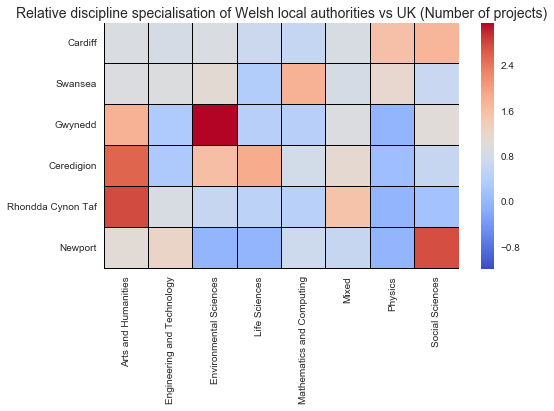

In [1346]:
#Map by LAD
lad_spec_lq = get_lq(pd.crosstab(places_projects_orgs_df['lad_name'],places_projects_orgs_df['topic_classified']))

lad_spec_wales_df = lad_spec_lq[[i in welsh_lads for i in lad_spec_lq.iloc[:,0]]]

#Some cleaning before plotting as heatmap
#Reset index
lad_spec_wales_df.set_index("lad_name",drop=True,inplace=True)
#Sort by total projects (numbers are small in some cases)
lad_spec_wales_df.sort(columns="total_projects",inplace=True,ascending=False)
#Focus on areas with more than 10 projects
lad_spec_wales_df_subset = lad_spec_wales_df[lad_spec_wales_df.total_projects>20]

#Drop the total project axis (which we don't want to visualise)
lad_spec_wales_df_subset.drop("total_projects",axis=1,inplace=True)

#Produce heatmap
fig,ax = plt.subplots(figsize=(8,6))
hm = sns.heatmap(lad_spec_wales_df_subset,cmap="coolwarm",center=1,linecolor="black",linewidths=0.01)
hm.set_title("Relative discipline specialisation of Welsh local authorities vs UK (Number of projects)",size=14)
fig.tight_layout()
ax.set(xlabel="",ylabel="")
plt.savefig("LAD_specialisation_heatmap.png")


### Revised network analysis:
* Assortativity analysis
 * Extract the Welsh and UK networks using the network extraction function, and compare the matrices.
* Network plotting. Subset the projects_org_places df by location (to capture all Welsh org ties) and produce a network. Subset and compare what this looks like depending on discipline (subset network by subject linl)?


In [1361]:
#Topic networks
#Only focus on projects with topics
places_projects_topics_df= places_projects_orgs_df[places_projects_orgs_df['topic_list'].notnull()]

#Extract Welsh Network
welsh_n =extract_network_from_corpus(places_projects_topics_df.ix[places_projects_topics_df.country=="Wales","topic_list"])

#Relabel the nodes using the right category
for node in welsh_n.node:
    welsh_n.node[node]['category']= grouped_topics_dict[topic_communities[node]]
    
#Create an assortivity matrix.

#This dict indexes category names vs matrix indices (we'll use it later for relabelling)
index_cat_map = {v:k for k,v in grouped_topics_dict.iteritems()}
# Extract index labels for df below. !!! This is hacky
index_labels = pd.DataFrame(index_cat_map,index=[1]).T.sort(columns=1,ascending=True).index

#Create assortativity matrix
welsh_ass_mat = nx.attribute_mixing_matrix(welsh_n,attribute="category",normalized=True,mapping=index_cat_map)

#Put it into a dataframe
welsh_ass_df = pd.DataFrame(welsh_ass_m,index=index_labels,columns=index_labels).fillna(value=0)

#Do the same thing for UK wide network (repeating ourselves...)
#Extract newtork
uk_n = extract_network_from_corpus(places_projects_topics_df['topic_list'])

#Create category labels using our previously created dicts
for node in uk_n.node:
    uk_n.node[node]['category'] = grouped_topics_dict[topic_communities[node]]
    
#Create assortativity matrix
uk_ass_mat = nx.attribute_mixing_matrix(uk_n,attribute="category",normalized=True,mapping=index_cat_map)
uk_ass_df = pd.DataFrame(uk_ass_mat,index=index_labels,columns=index_labels)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [1362]:
#Produce heatmap
fig,ax = plt.subplots(figsize=(8,6))
hm = sns.heatmap(welsh_ass_df/uk_ass_df,cmap="coolwarm",center=1,linecolor="black",linewidths=0.01)
hm.set_title("Discipline mixing in Wales compared to GB",size=14)
fig.tight_layout()
plt.savefig("discipline_mixing_heatmap.png")
plt.close()

# !!! Todo: check the definition of the assortativity matrix. How are the probabilities calculated?

<img src="discipline_mixing_heatmap.png" align="left">

In [1436]:
#Extract the network of Welsh collaborations
welsh_network = extract_network_of_interest(interaction_df==org_network_df,
                                            edge_attr="topic_classified")

#Label the graph
welsh_network.graph['country']="Wales"

#Add place metadata to the network using the org_geo_lu dict.
for node in welsh_network.node:
    welsh_network.node[node]['country']=org_geo_lu_dict[node]['CTRY13NM']
    welsh_network.node[node]['lad']=org_geo_lu_dict[node]['LAD13NM']

network_stats_list=[]
network_comparisons_list =[]
    
#Output a network for each discipline (including "mixed")
for disc in grouped_topics_dict.values() + ["Mixed"]:
    #Create discipline network
    subset_net = subset_by_edge_attribute(welsh_network,attribute_val=disc)

    #Label network by discipline
    subset_net.graph['discipline']=disc
    
    #Extract relevant stats
    network_stats_list.append(extract_network_statistics(subset_net))
    
    #Create network comparisons and append to output list
    network_comparisons_list.append(compare_networks(subset_net,'Wales',disc))
    
    #Gephi doesn't like graphs with attributes. Delete before outputting
    del subset_net.graph['discipline']
    del subset_net.graph['country']
    
    #Write network out
    nx.write_graphml(subset_net,
                     net_path+"welsh_network_{}.graphml".format(disc))    
    
    plt.close()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:55: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:108: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:109: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
